In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hw2_1 import *
from torch.optim import Adam
from torch.autograd import Variable
from tqdm.notebook import tqdm
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys
import subprocess
import random

In [3]:
batch_size = 128
lr = 0.0002
b1 = 0.5
b2 = 0.999
epochs = 300
manualSeed = 777
random.seed(manualSeed)
torch.manual_seed(manualSeed)
test_noise = torch.randn(1000, 100, 1, 1, device='cuda')
fixed_noise = torch.randn(64, 100, 1, 1, device='cuda')

criterion = nn.BCELoss()
generator = MyGenerator().cuda()
discriminator = MyDiscriminator().cuda()

generator.apply(weights_init)
discriminator.apply(weights_init)

dataloader = loadData('hw2_data/face/train/',batch_size,12)
optimizer_G = torch.optim.Adam(generator.parameters(),lr=lr,betas=(b1,b2),weight_decay=0.0002 / epochs)
optimizer_D = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(b1,b2),weight_decay=0.0002 / epochs)

In [4]:
def val():
    #generator.eval().cuda()
    with torch.no_grad():
        test_img = generator(test_noise).detach().cpu()
    
    for i in range(1000):
        save_image(test_img[i],'p1_result/'+str(i)+'.png', normalize=True)
    
    FID = subprocess.run([sys.executable,'-m','pytorch_fid','p1_result/','hw2_data/face/val','--device', 'cuda:0'],capture_output=True)
    FACE = subprocess.run([sys.executable,'face_recog.py','--image_dir','p1_result/'],capture_output=True)
    print(FID.stdout.decode(),end='')
    print(FACE.stdout.decode())

In [5]:
img_list = []
G_loss = []
D_loss = []
iters = 0

for epoch in tqdm(range(epochs)):
    for i ,data in enumerate(dataloader,0):
        data = data.cuda()
        optimizer_D.zero_grad()
        label = torch.full((data.shape[0],), 1.0, dtype=torch.float, device='cuda')
        label += 0.05 * torch.randn((data.shape[0],),device='cuda')
        output = discriminator(data).view(-1)
        real_loss = criterion(output,label)
        real_loss.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(data.shape[0],100,1,1,device='cuda')
        fake = generator(noise)
        label.fill_(0.0)
        label += 0.05 * torch.randn((data.shape[0],),device='cuda')
        output = discriminator(fake.detach()).view(-1)
        fake_loss = criterion(output,label)
        fake_loss.backward()
        D_G_z1 = output.mean().item()
        
        d_loss = real_loss + fake_loss
        optimizer_D.step()
        
        optimizer_G.zero_grad()
        label.fill_(1.0)
        output = discriminator(fake).view(-1)
        g_loss = criterion(output,label)
        g_loss.backward()
        
        D_G_z2 = output.mean().item()
        optimizer_G.step()
        
#         if i % 50 == 0:
#             print('[%3d/%3d][%3d/%3d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                   % (epoch, epochs, i, len(dataloader),
#                      d_loss.item(), g_loss.item(), D_x, D_G_z1, D_G_z2))
            
        G_loss.append(g_loss.item())
        D_loss.append(d_loss.item())
        
#         if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = generator(fixed_noise).detach().cpu()
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
#             save_image(fake.data[:25], "p1_result/%d.png" % iters, nrow=5, normalize=True)
        iters += 1
    if(epoch%10==0):
        print("Epoch:",epoch)
        print("Gen loss: ",G_loss[-1],"Dis loss: ",D_loss[-1])
        val()
        

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0
Gen loss:  7.042835235595703 Dis loss:  0.7435821294784546
FID:  293.5290818140968
Face recognition Accuracy: 35.600%

Epoch: 10
Gen loss:  5.505324363708496 Dis loss:  0.9874961376190186
FID:  73.56566993236723
Face recognition Accuracy: 87.400%

Epoch: 20
Gen loss:  2.403667688369751 Dis loss:  0.4763033390045166
FID:  59.41836185917981
Face recognition Accuracy: 87.300%

Epoch: 30
Gen loss:  2.2859580516815186 Dis loss:  0.5187075734138489
FID:  41.10473100618958
Face recognition Accuracy: 87.300%

Epoch: 40
Gen loss:  4.574116230010986 Dis loss:  0.4329478442668915
FID:  36.80078990252005
Face recognition Accuracy: 86.000%

Epoch: 50
Gen loss:  3.009950637817383 Dis loss:  0.3062751591205597
FID:  37.28975120176278
Face recognition Accuracy: 86.600%

Epoch: 60
Gen loss:  7.86749267578125 Dis loss:  0.5255427360534668
FID:  32.617097492105074
Face recognition Accuracy: 88.400%

Epoch: 70
Gen loss:  1.0921876430511475 Dis loss:  1.0211849212646484
FID:  31.492497735673908
Fa

In [11]:
with torch.no_grad():
    fake = generator(test_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    save_image(fake.data[:32], "p1_2.png" , nrow=8, normalize=True)

In [7]:
print(generator)
print(discriminator)

MyGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


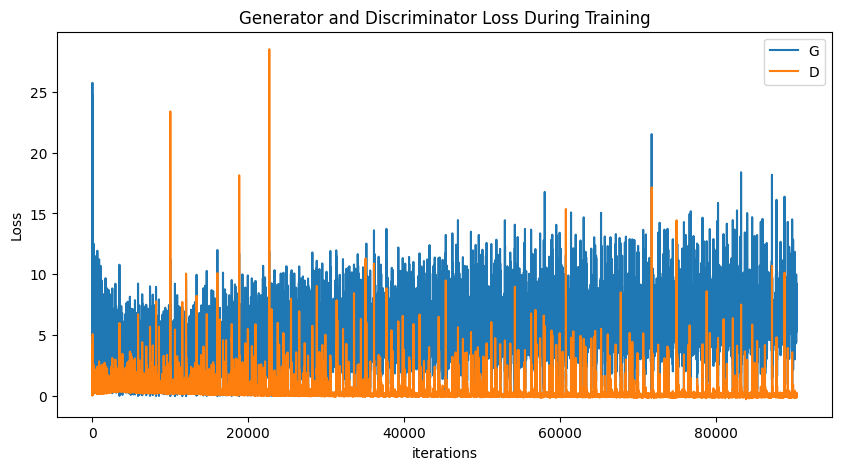

In [8]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [9]:
val()

FID:  26.58724684839953
Face recognition Accuracy: 90.200%



In [10]:
def saveModel():
    path = "./hw2_1_gen.pth"
    torch.save(generator.state_dict(), path)
saveModel()